<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/malaria_botelladetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTE MODELO TIENE TRES PROBLEMAS: INFIERE AL 100X100 DE PRECISION.
NO SE SABE DE DONDE TOMA LOS PESOS NI EN Q PARTE LOS INJECTA.
AL FINAL MUESTRA POCAS FOTOS DESPUES DE INFERIR LA CARPETA DE VALIDACION

In [18]:
from google.colab import drive

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
import cv2

img = cv2.imread("/content/drive/MyDrive/malaria_botellas/Parasitized/anomalo1.jpg")
img.shape

(480, 640, 3)

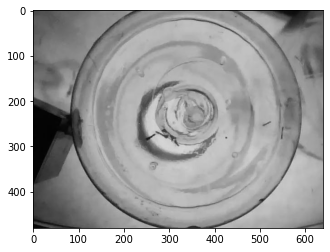

In [243]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [244]:
img_dir = "/content/drive/MyDrive/malaria_botellas"



In [245]:
import tensorflow as tf

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,                                                                                                                   
                                                           #rotation_range=0.2,  "estos 4 hacen preprocesado"
                                                           #width_shift_range=0.2,
                                                           #height_shift_range=0.2,
                                                           #zoom_range = 0.2, 
                                                           horizontal_flip=True,
                                                           validation_split = 0.25
                                                            )
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.25
                                                          )

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.50
                                                          )



In [219]:
train_data = train_gen.flow_from_directory(img_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 32,
                                           classes = ["Parasitized","Uninfected"],
                                           seed = 42,
                                           subset = "training"                                           
                                           )

test_data = test_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Parasitized","Uninfected"],
                                         batch_size = 32,
                                         seed = 42,
                                         subset = "validation"
                                         )

val_data = val_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Paraval","Unival"],
                                         batch_size = 32,
                                         seed = 42,
                                         subset = "validation"
                                         )

Found 688 images belonging to 2 classes.
Found 228 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


In [167]:
class_labels = list(train_data.class_indices.keys())

class_labels

['Parasitized', 'Uninfected']

In [168]:
class_labels = list(test_data.class_indices.keys())

class_labels

['Parasitized', 'Uninfected']

In [169]:
class_labels = list(val_data.class_indices.keys())

class_labels

['Paraval', 'Unival']

In [170]:
image,label = train_data.next()
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 2)


In [171]:
image,label = val_data.next()
print(image.shape)
print(label.shape)  # el 1er numero el el batch siza elegido x mi arriba

(8, 224, 224, 3)
(8, 2)


ValueError: ignored

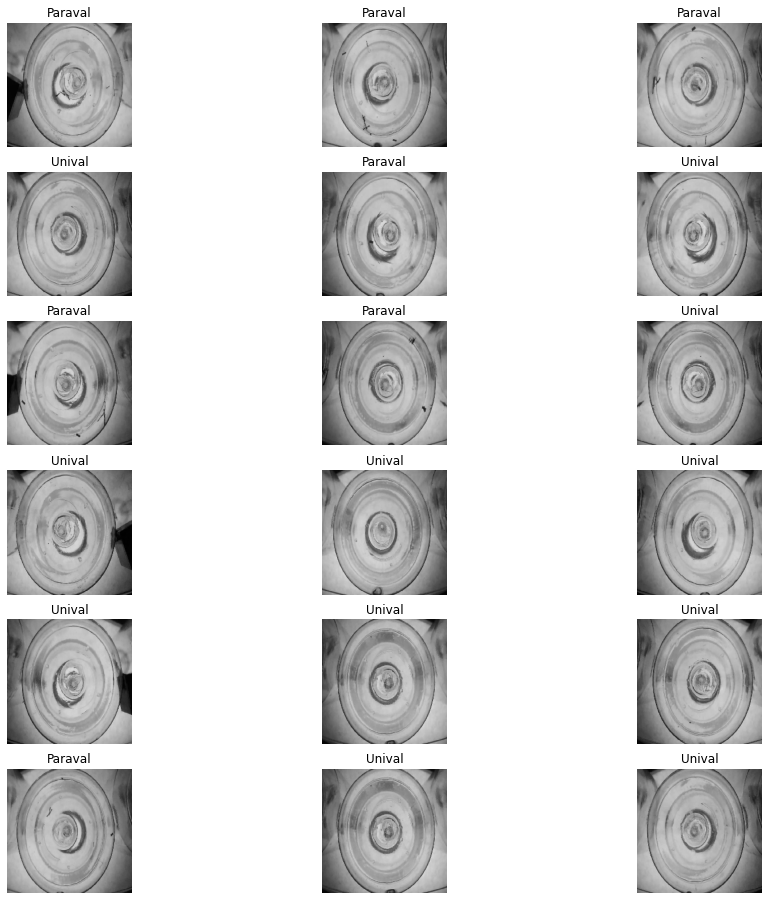

In [220]:
# visualizing the train,  or val ,or test  data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(19):

  image,label = train_data.next()## visualizar x data

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(class_labels[tf.argmax(label[i])])
  plt.axis("off")


In [221]:
#building a CNN model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             layers.Conv2D(filters=64, kernel_size= 2, activation="relu", input_shape=(224,224,3)),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation="relu"),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation= "relu"),
                             layers.MaxPooling2D(pool_size = 2),


                             layers.Flatten(),

                             layers.Dense(128, activation= "relu"),
                             layers.Dropout(0.5),
                             layers.Dense(2, activation="softmax"),
])


In [174]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 223, 223, 64)      832       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 110, 110, 64)      16448     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 54, 54, 64)        16448     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 27, 27, 64)      

In [222]:
# compiling the model

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [239]:
# fitting data to the model
model.fit(train_data,
          epochs = 1,
          steps_per_epoch = len(train_data),
          validation_data = test_data,  # test data o val data, para elegir contra que muestras convalidar la precision del modelo al entrenar
          validation_steps = len(test_data)
          )

22/22 [==============================] - 7s 331ms/step - loss: 0.0127 - accuracy: 0.9971 - val_loss: 5.5862e-04 - val_accuracy: 1.0000


In [246]:
model_evaluation = model.evaluate(train_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

22/22 [==============================] - 5s 225ms/step - loss: 0.0011 - accuracy: 1.0000


In [248]:
model_evaluation = model.evaluate(test_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

8/8 [==============================] - 2s 199ms/step - loss: 5.5862e-04 - accuracy: 1.0000


In [ ]:
model_evaluation = model.evaluate(val_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

3/3 [==============================] - 1s 120ms/step - loss: 3.9987e-04 - accuracy: 1.0000


IndexError: ignored

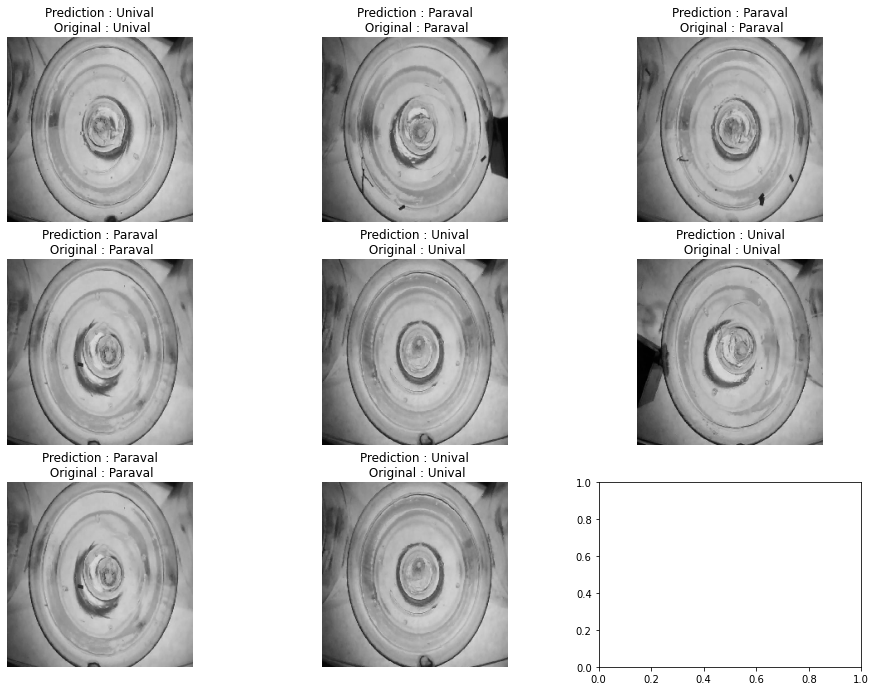

In [241]:
# visualizing the train data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = val_data.next()

  model_pred = model.predict(image)

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(f"Prediction : {class_labels[tf.argmax(model_pred[i])]}\n Original : {class_labels[tf.argmax(label[i])]}")
  plt.subplots_adjust(top = 1.25)
  plt.axis("off")